# **PCA, MCA and hierarchical classification**
By Amin.Bl 
______________________________________________________________________________________________________________________________

# Introduction

The objectives of this analysis are to:

   - identify groups of similar cars (according to the brand, the producing country or other mechanical characteristics);
   - determine which variables make one group different from another;
   - determine the variables that have the most impact on the number of sales, the price as well as the efficiency of fuel consumption

Three different methods will be used :

   - Principal Component analysis (PCA)
   - the hierarchical classification (ward method)
   - Multiple Correspondence analysis
    

let's import the necessary libraries 

In [1]:
library("ggplot2")
library("FactoMineR")
library("factoextra")
library("corrplot")
library("PerformanceAnalytics")

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.84 loaded

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend




In [2]:
#resize the plot output
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(13,13)

# Data presentation, descriptive analysis

The original dataset contains 157 observations which are reduced to 117 observations after removing the missing data. Imputation is not implemented since the number of observations is more than enough to make the necessary analyzes.

In [3]:
#upload the dataset
      Car_sales <- read.csv(file="../input/car-sales-nationnality/Car_sales.csv",sep=";", dec=",", header=TRUE)
#remove the rows with missing data ( original : 157 obs 16 var)
      Car_sales <- na.omit(Car_sales)

For clarity, the numbering of the first column has been replaced by a variable of single value corresponding to a merge between the variable "Manufacturer" and "Model" of car: Manufacturer_Model.

A new qualitative variable is added representing the country of origin of automobile manufacturer (https://fr.wikipedia.org/wiki/Constructeur_automobile). After some adaptations (discretization, merging of two variables, deletion of variables which are not necessary for our analysis) our database is limited to 117 observations, 9 quantitative variables and 2 qualitative variables.

The variables in this dataset are as follows:

  * **"Sales_in_thousands"**: the number of sales per thousand
  * **"Engine_size"**: the volume of the cylinder
  * **"Horsepower"**: the number of horses
  * **"Wheelbase"**: the distance between the end axles of a vehicle
  * **"Width"**: the width of the vehicle
  * **"Length"**: the length of the vehicle
  * **"Curb_weight"**: the empty mass in running order
  * **"Fuel_capacity"**: the fuel tank capacity
  * **"Fuel_efficiency"**: fuel efficiency (gallon / miles)
  * **"Nationnality"**: the country of origin of automobile manufacturer
  * **"Price_level"**: the vehicle price category: LOW <20K, Medium (20.35], high> 35K
  
  

In [4]:
Car_sales$Manufacter_Model <- paste(Car_sales$Manufacturer, "_",  Car_sales$Model)
      rownames(Car_sales) <- Car_sales$Manufacter_Model
      Car_sales$Model <- NULL
      Car_sales$Manufacturer <- NULL
      Car_sales$Manufacter_Model <- NULL
# discretization of variable "Price_in_thousands" to "Price-level"
        Car_sales$Price_in_thousands <- as.numeric(Car_sales$Price_in_thousands)
        Car_sales$Price_level <- cut(Car_sales$Price_in_thousands, c(0,20,35,83))
        Car_sales$Price_level <- as.factor(ifelse((Car_sales$Price_level == "(0,20]"), "Low_Price",ifelse((Car_sales$Price_level == "(20,35]"), "Medium_Price",
        ifelse((Car_sales$Price_level == "(35,83]"),  "High_Price", NA))))
        Car_sales$Price_in_thousands <- NULL
#Log10 of variable "Sales_in_thousands" : pas d'amelioration 
#       Car_sales$Sales_in_thousands = log10(Car_sales$Sales_in_thousands)+1
 #deletion of variables which are not necessary for our analysis
        Car_sales$Latest_Launch <- NULL
        Car_sales$Vehicle_type <- NULL     
        Car_sales$X__year_resale_value <- NULL
        Car_sales$Power_perf_factor <- NULL

According to the histograms shown below and the output of the summary () function, the distribution of the quantitative variables is approximately normal except for the variable "Sales_in_thousands" which is left-skewed and could be solved by applying a logarithmic transformation.

In [5]:
summary(Car_sales)
head(Car_sales,3)

 Sales_in_thousands  Engine_size      Horsepower      Wheelbase    
 Min.   :  0.11     Min.   :1.000   Min.   : 55.0   Min.   : 92.6  
 1st Qu.: 16.77     1st Qu.:2.200   1st Qu.:140.0   1st Qu.:102.4  
 Median : 32.30     Median :3.000   Median :175.0   Median :107.0  
 Mean   : 59.11     Mean   :3.049   Mean   :181.3   Mean   :107.3  
 3rd Qu.: 76.03     3rd Qu.:3.800   3rd Qu.:210.0   3rd Qu.:111.6  
 Max.   :540.56     Max.   :8.000   Max.   :450.0   Max.   :138.7  
     Width           Length       Curb_weight    Fuel_capacity  
 Min.   :62.60   Min.   :149.4   Min.   :1.895   Min.   :10.30  
 1st Qu.:68.50   1st Qu.:177.5   1st Qu.:2.911   1st Qu.:15.30  
 Median :70.40   Median :187.8   Median :3.340   Median :17.20  
 Mean   :71.19   Mean   :187.7   Mean   :3.324   Mean   :17.81  
 3rd Qu.:73.60   3rd Qu.:196.5   3rd Qu.:3.823   3rd Qu.:19.80  
 Max.   :79.30   Max.   :224.5   Max.   :5.115   Max.   :32.00  
 Fuel_efficiency       Nationnality       Price_level
 Min.   :15.00 

,Sales_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Nationnality,Price_level
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>
Acura _ Integra,16.919,1.8,140,101.2,67.3,172.4,2.639,13.2,28,Japon,Medium_Price
Acura _ TL,39.384,3.2,225,108.1,70.3,192.9,3.517,17.2,25,Japon,Medium_Price
Acura _ RL,8.588,3.5,210,114.6,71.4,196.6,3.850,18.0,22,Japon,High_Price


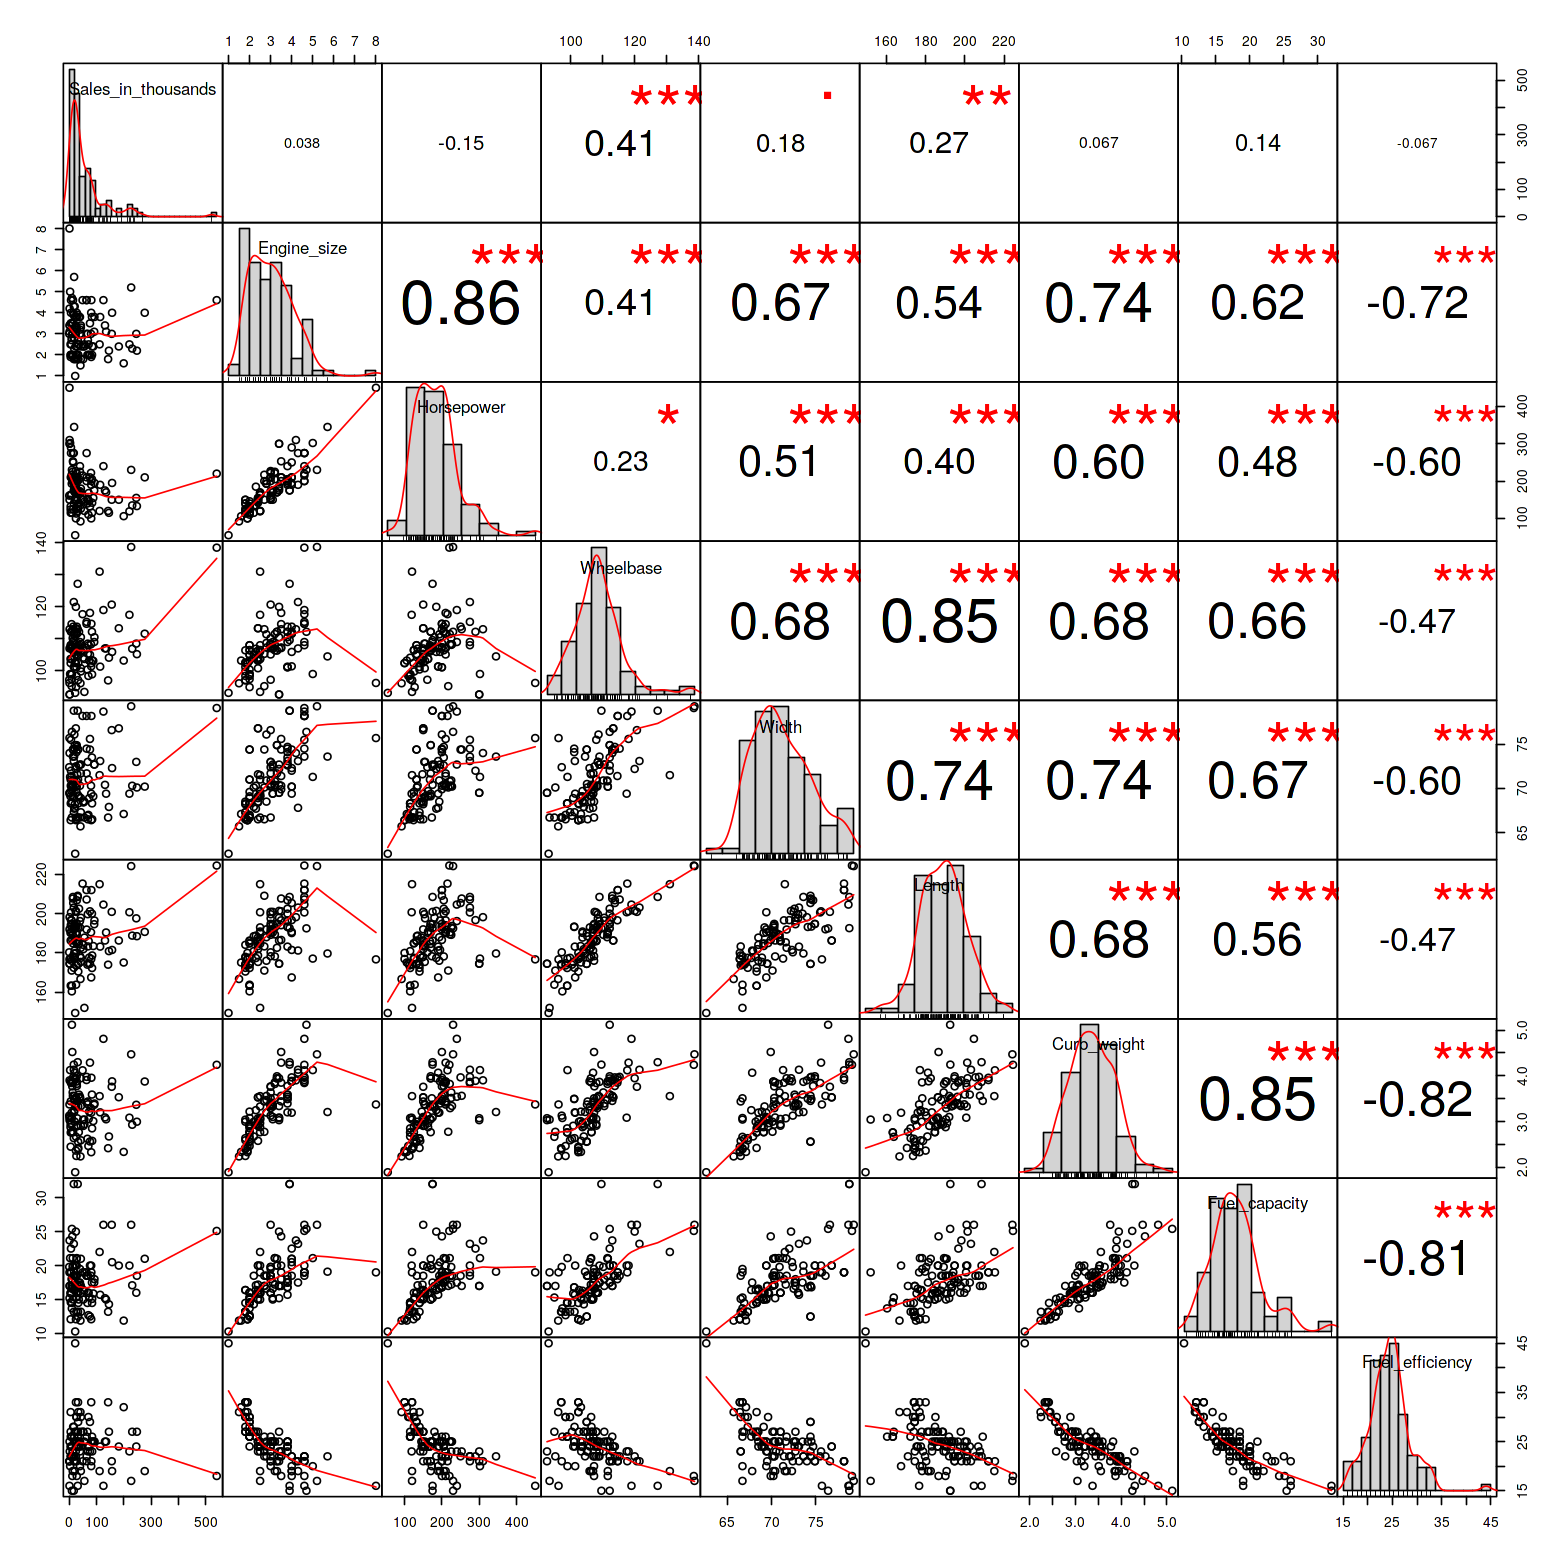

In [6]:

chart.Correlation(Car_sales[, 0:9], histogram=TRUE, pch=19)

## correlation matrix and ${\chi}^2$ test

As shown below,  there is a strong positive correlation between the quantitative variables describing the mechanical characteristics such as dimensions, engine power and tank capacity.As we would expect, these variables are negatively correlated with fuel efficiency.

Regarding the variable describing the number of sales, it turns out that there is little correlation with the other quantitative variables except for the variable "Wheelbase" where the correlation coefficient is equal to 0, 4. 

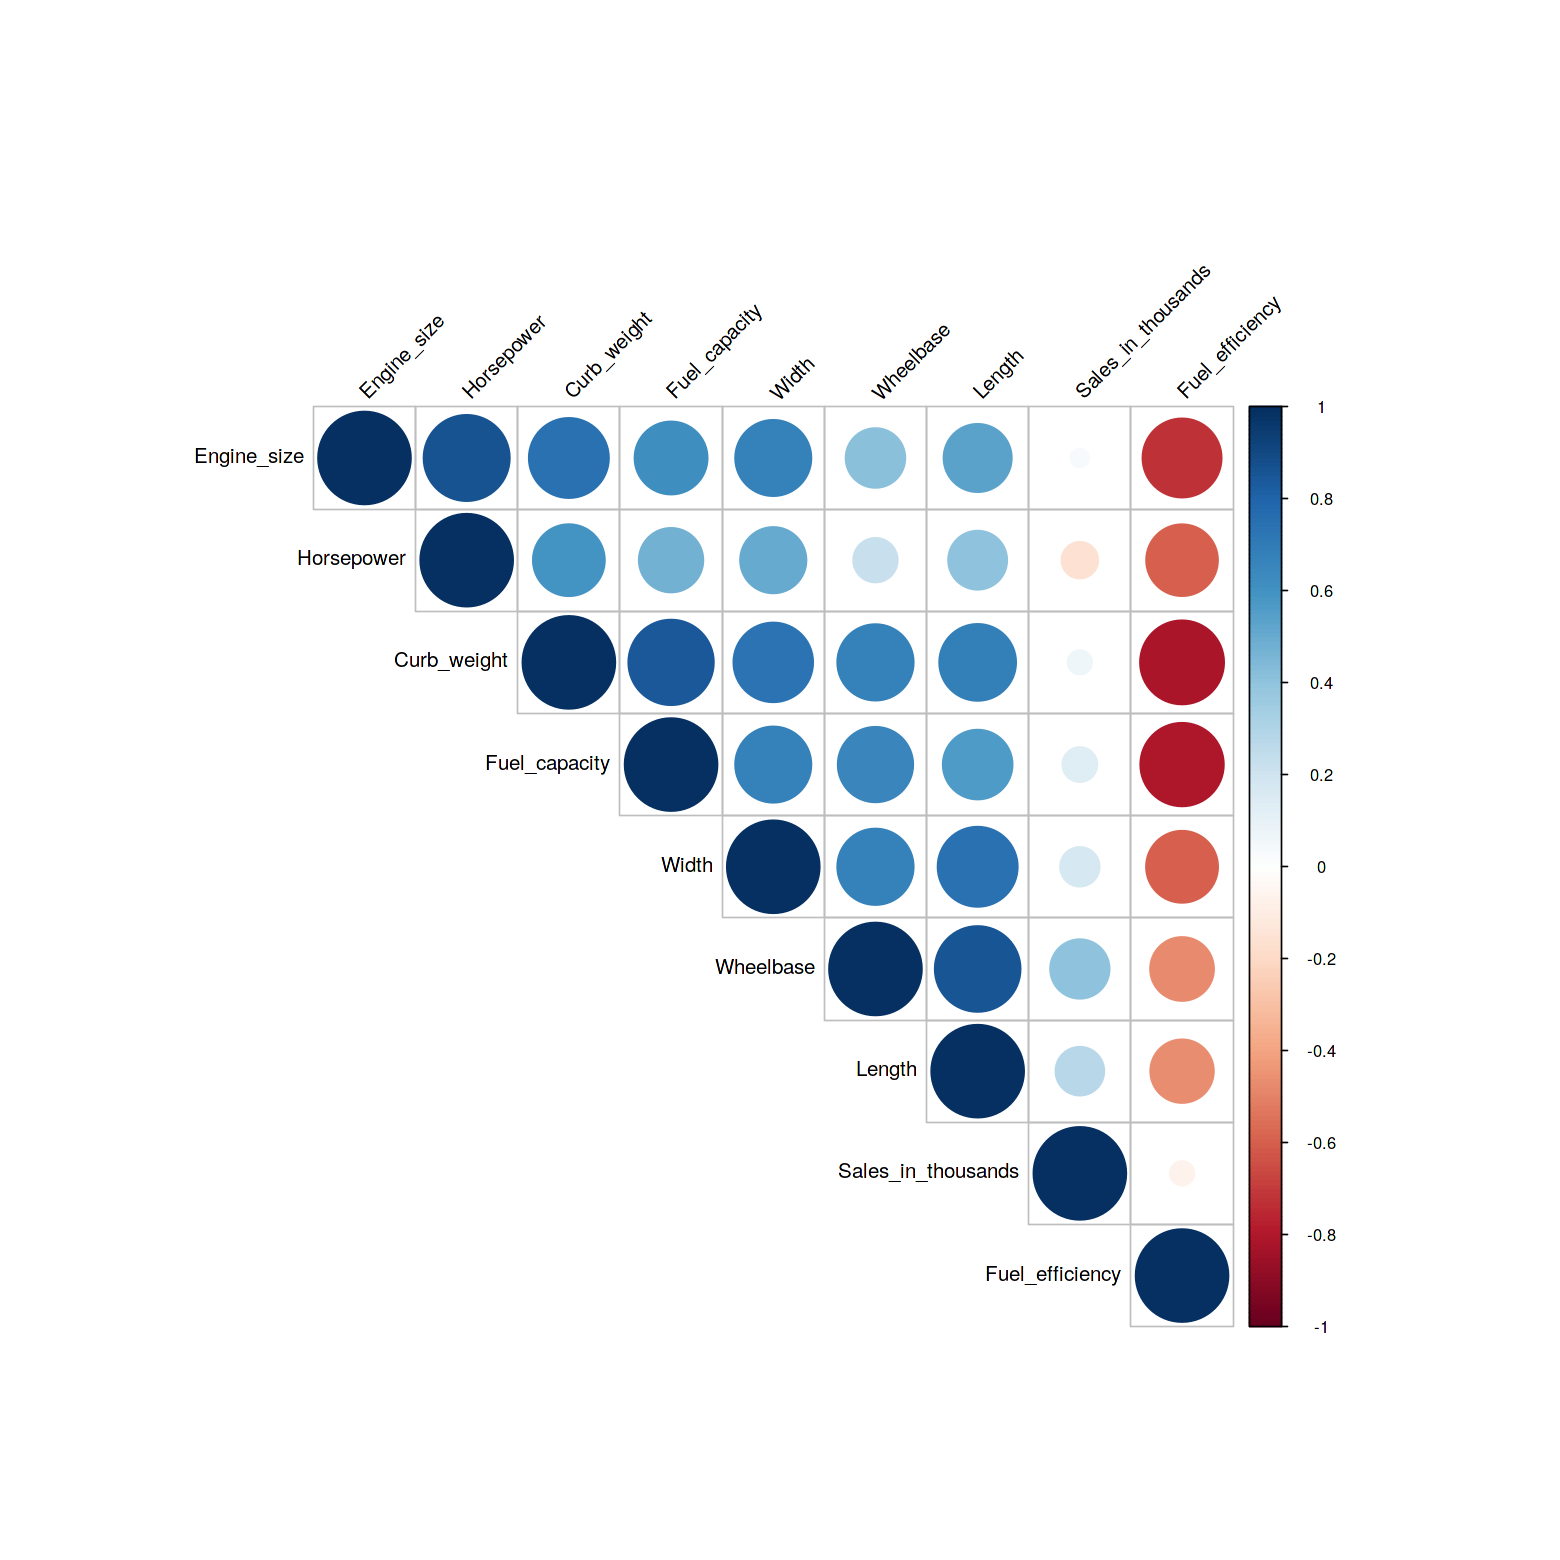

In [7]:
corrplot(cor(Car_sales[,0:9]), type="upper", order="hclust", tl.col="black", tl.srt=45)

Before doing the principal component analysis, it is necessary to check the dependency of our variables. The test of ${\chi}^2$ reject the hypothesis that there is no relationship between the variables  with a p-value less than 2.2 e-16

In [8]:
chisq.test(Car_sales[,1:9])

Warning message in chisq.test(Car_sales[, 1:9]):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  Car_sales[, 1:9]
X-squared = 9381.8, df = 928, p-value < 2.2e-16


# Principal component analysis

In the principal component analysis, our quantitative variables are standardized and normalized before analysis (scale.unit = TRUE) in order to make them comparable.

Looking at the eigenvalues mentioned below, the first two dimensions contain 78% of the total inertia. This percentage is acceptable to keep the first two main axes for the rest of our analysis.

,eigenvalue,variance.percent,cumulative.variance.percent
Dim.1,5.4742246,60.824718,60.82472
Dim.2,1.5027506,16.697229,77.52195
Dim.3,0.6555215,7.283572,84.80552
Dim.4,0.6275862,6.973180,91.77870
Dim.5,0.2764876,3.072084,94.85078


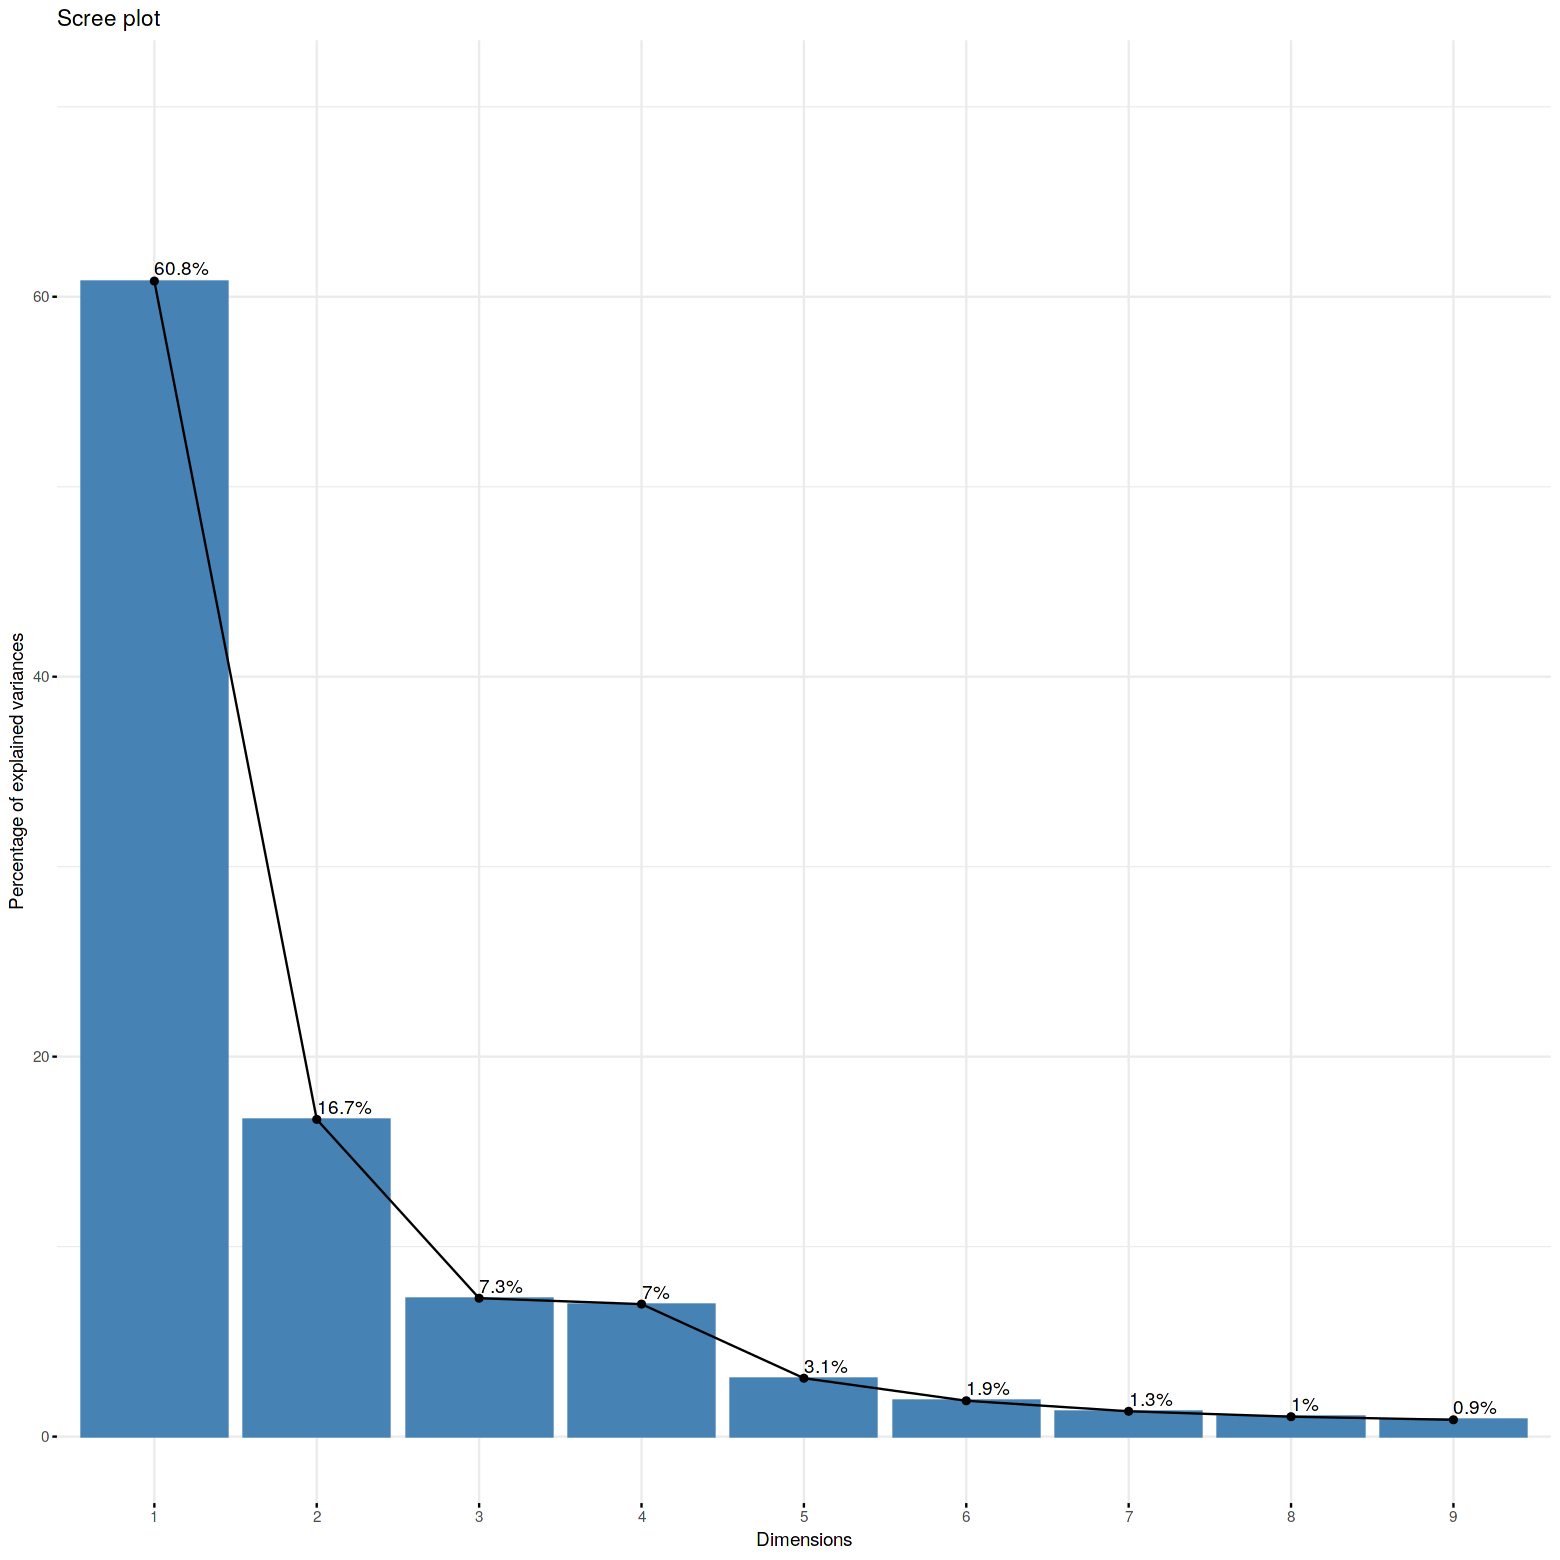

In [9]:
 res.pca<- PCA(Car_sales,scale.unit = TRUE,  graph = FALSE,quali.sup = c(10,11))
 get_eigenvalue(res.pca)[0:5,]

#eigenvalues / Variances
fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 70))

The graph of the variables shown below shows that the variable "Engine_size" and "Horsepower" are negatively correlated with the variable "Fuel_efficiency". These results seem to be quite logical, because the larger and more powerful an engine, the higher its consumption will be. Therefore, the energy efficiency will be low (this corresponds to a high value in liter / km or gallon / miles).

The "sales_in_thousands" variable is not very correlated with the "Horspower" "Engine_size" and "Fuel_efficiency" variables because these variables form approximately a right angle. This means that the volume as well as the engine power don't affect directly the sales.

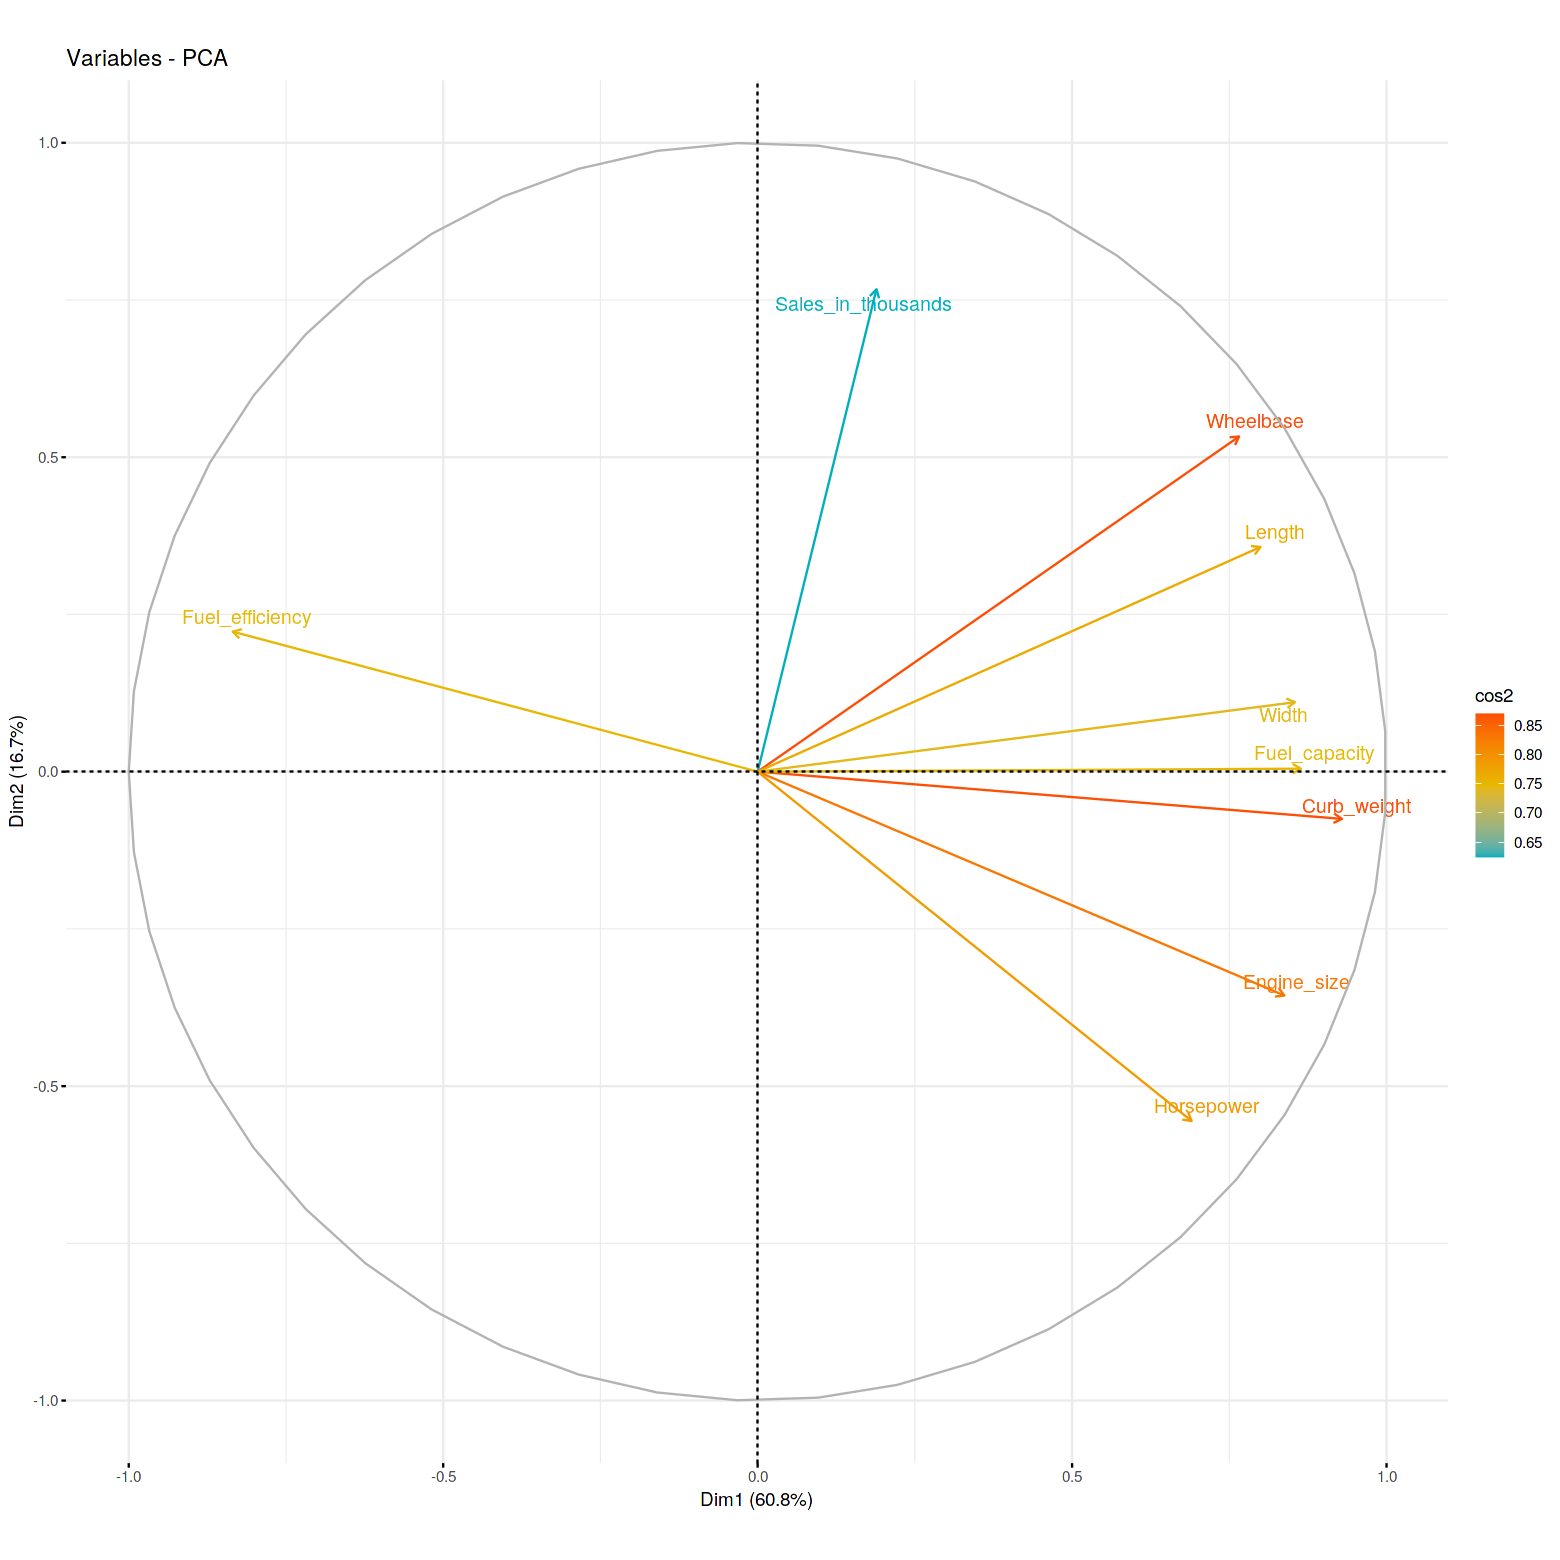

In [10]:
fviz_pca_var(res.pca, col.var = "cos2",
            gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
            repel = TRUE)

For a clear visualization of individuals and avoidance of overlapping text, only the twenty main contributors to the main axes have been represented (select.ind = list (contrib = 20). The first axis opposes vehicles which are big volume, large tank and with a powerful engine like Ford_expedition to the one with fuel-efficient like Chevrolet metro. The second axis opposes top-selling vehicles like Ford_F-series to lesser selling ones like Dodge_viper

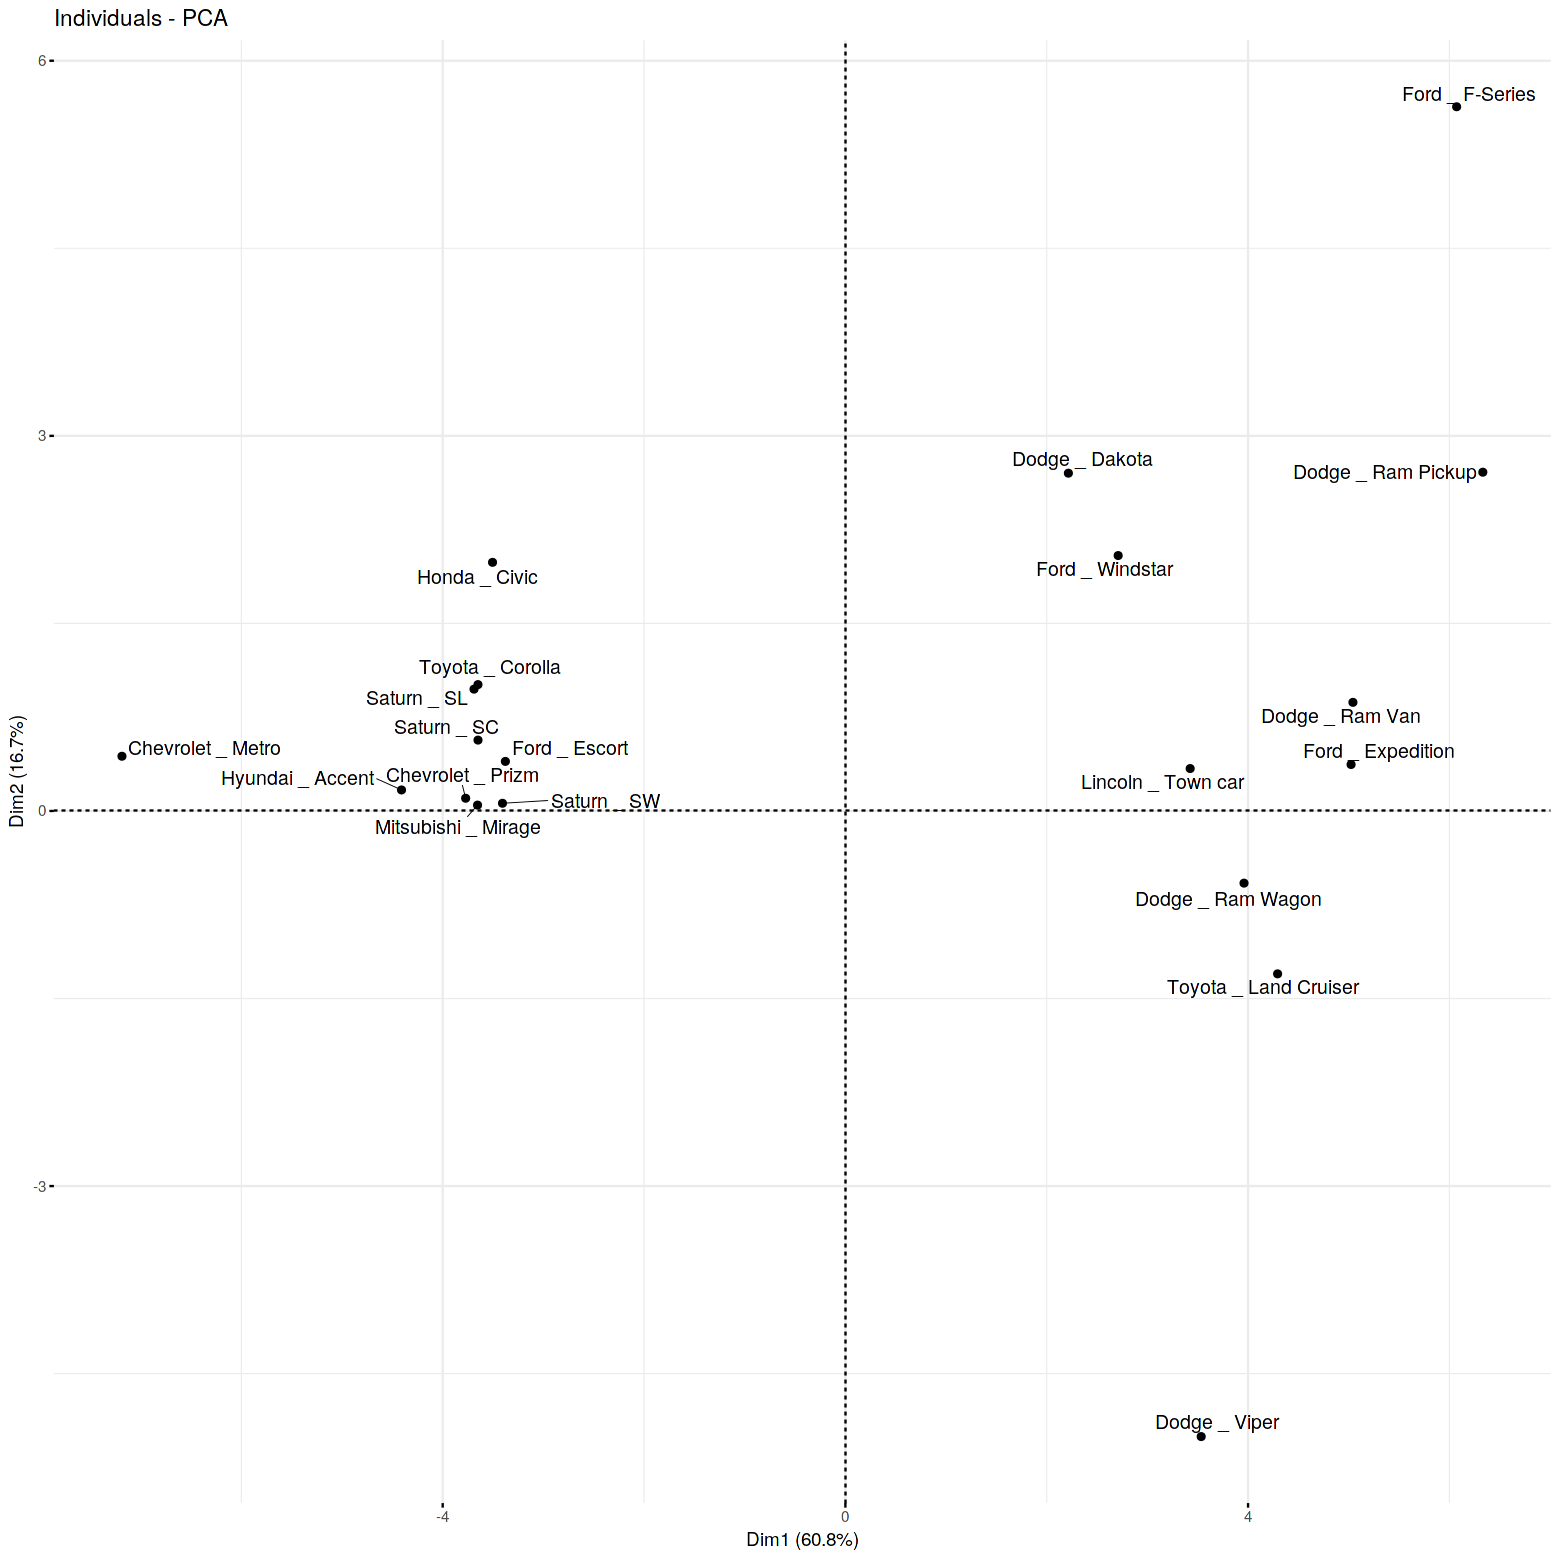

In [11]:
fviz_pca_ind (res.pca, select.ind = list(contrib = 20), repel = TRUE)

The two graphs, below, show the individuals with the color markers indicating the values of  the two qualitative variables ("Price_level" and "Nationnality"). We can see that the best-selling vehicles are mostly American brands with a low price. We can also notice that the cheapest vehicles have good energy efficiency and conversely, the most expensive vehicles have poor energy efficiency.

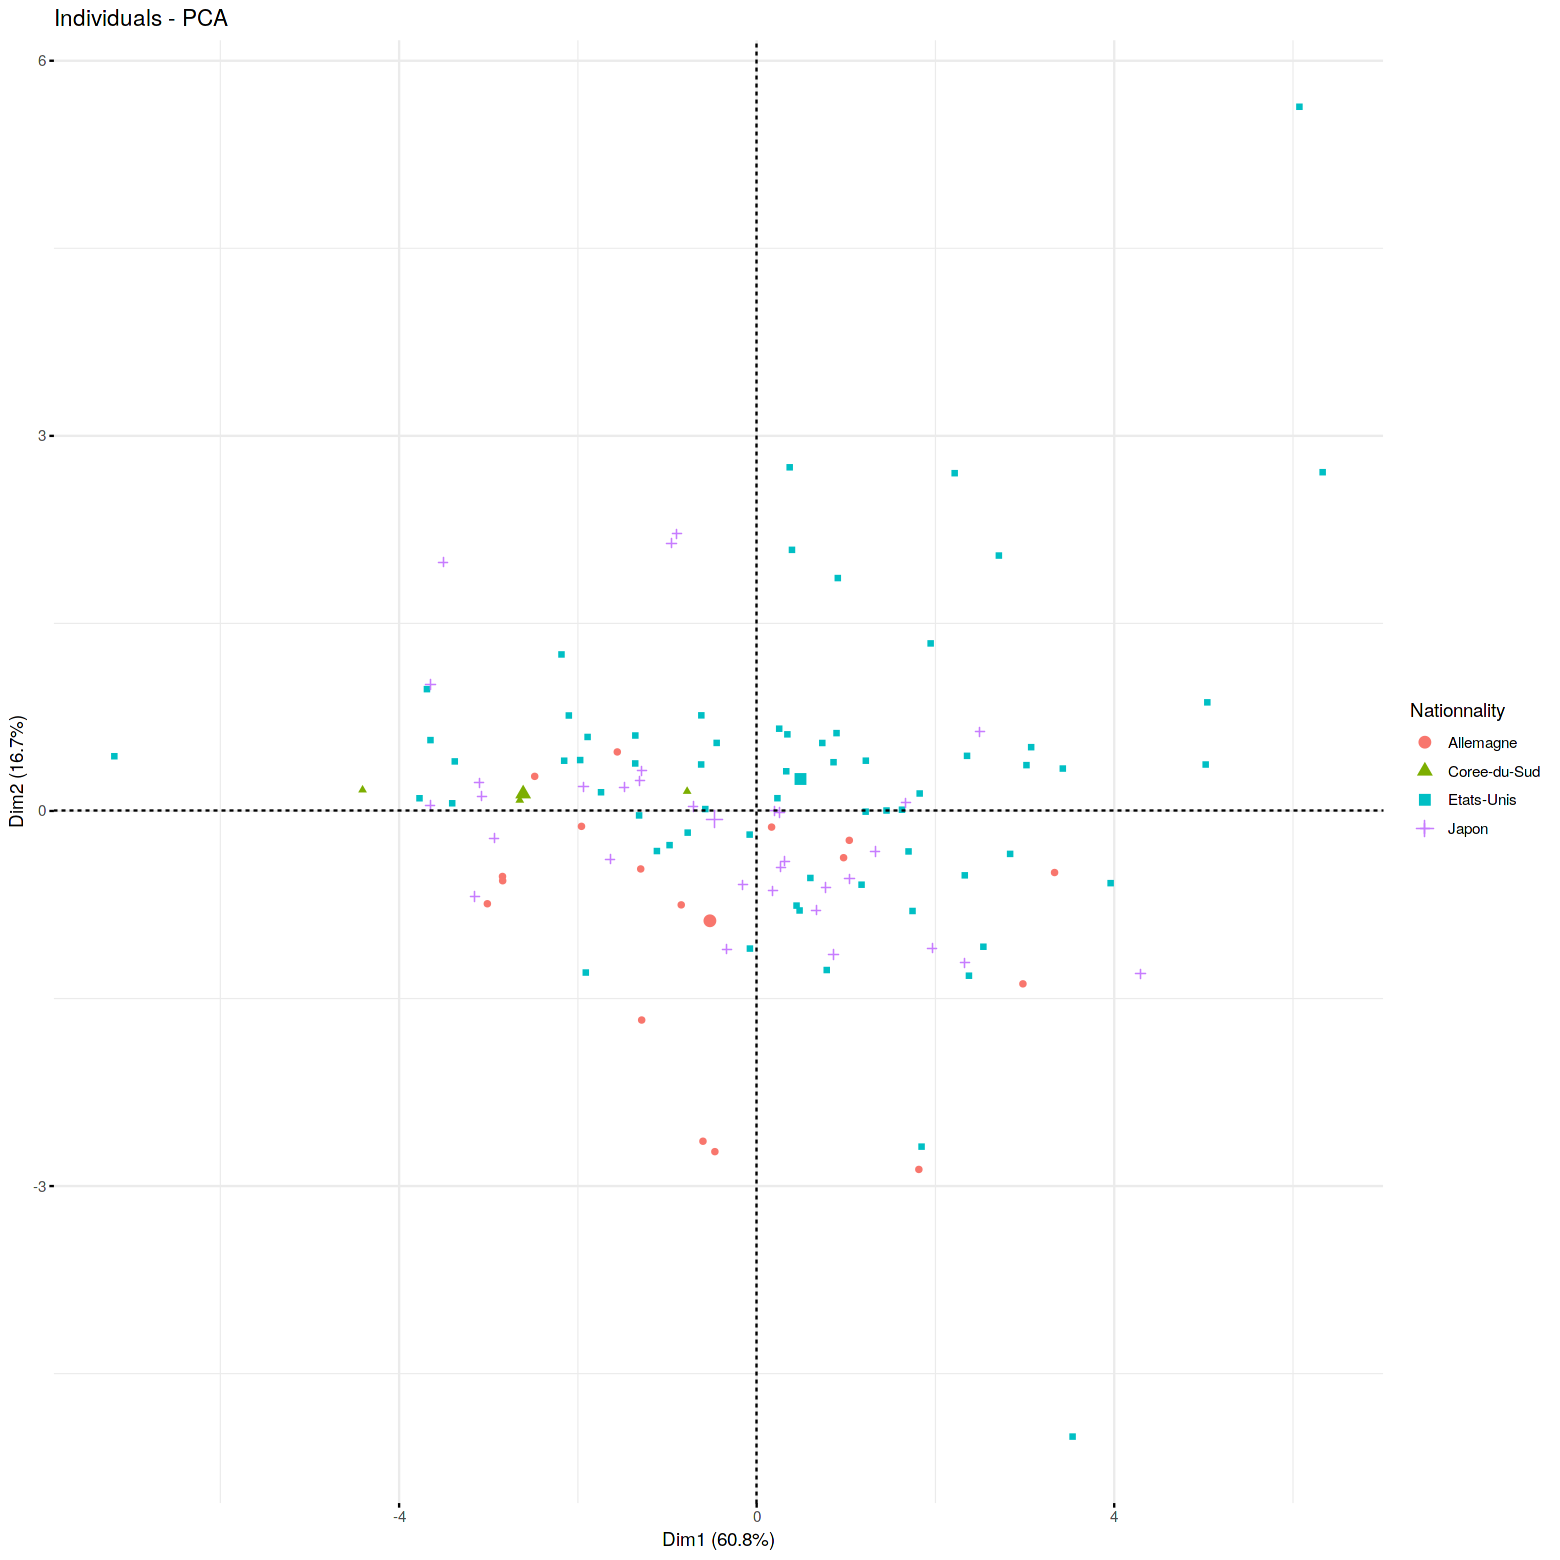

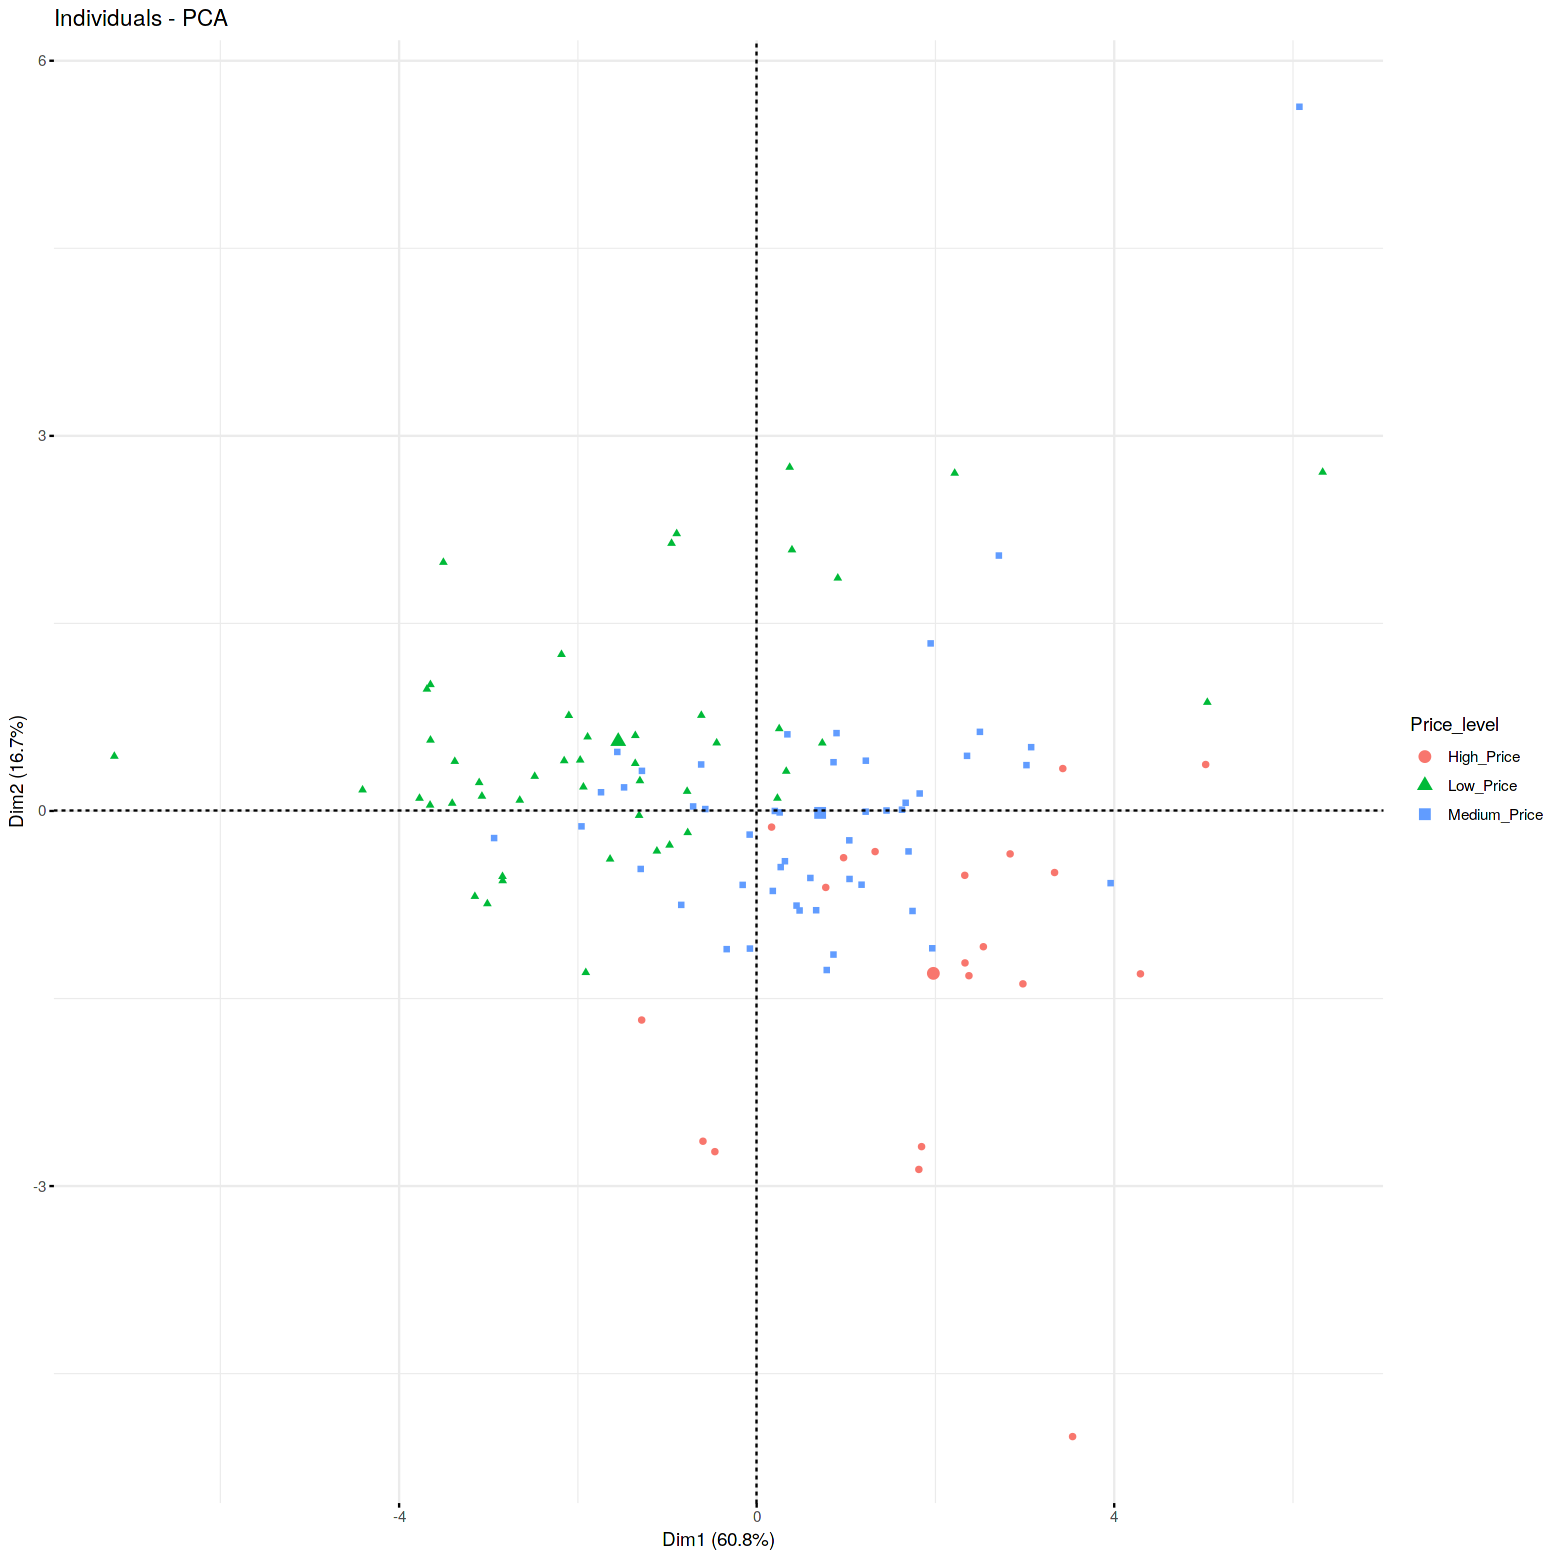

In [12]:
fviz_pca_ind(res.pca,habillage=10, label = "quali")

fviz_pca_ind(res.pca,habillage=11, label = "quali")

# the hierarchical classification

In the Clustering analysis, we can apply the hierarchical classification (ward method), using the bar diagram which represents the inertia jumps of the dendrogram, this allowed us to deduce that there are 6 classes, then, by calculating the percentage of BSS and TSS corresponding respectively to "Between Sum of Squares" and "Total Sum of Squares", we can assume that this partition represents a good quality which is equal to 85%

BSS/TSS*100:  84.93793

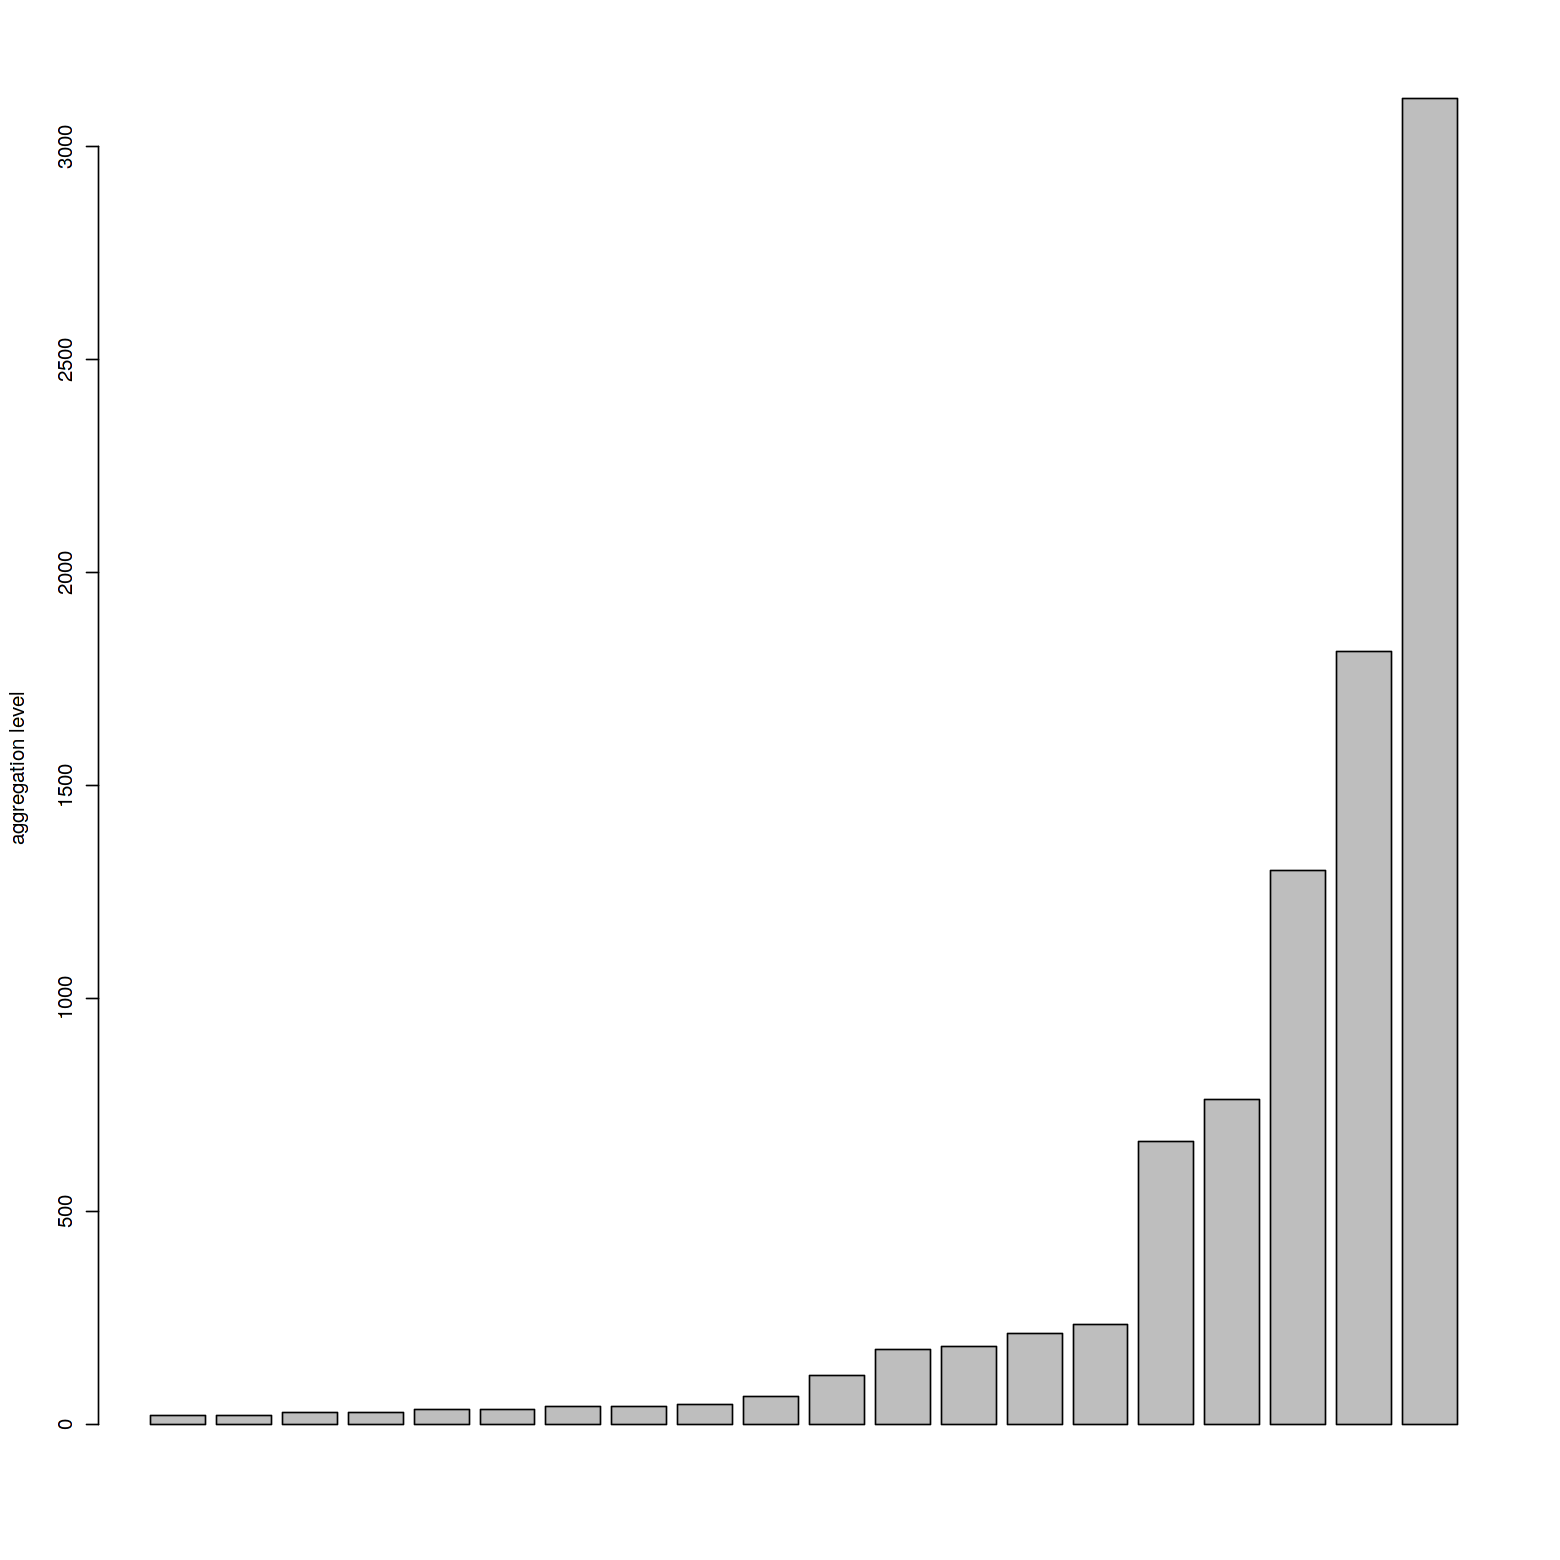

In [13]:
# H. clust methode de ward
      res.hclust <- hclust(dist(Car_sales[0:9])^2 / (2 * nrow(Car_sales)), method = "ward.D")
      
      barplot(tail(res.hclust$height, n = 20),ylab = "aggregation level")
     
      TSS <- sum(res.hclust$height)
      BSS <- sum(tail(res.hclust$height,n=(7-1)))
      cat("BSS/TSS*100: ", BSS/TSS*100)  

The dendrogram shows that the first group (in dark blue) represents only one element (Ford _ F-Series) that can be considered an "outlier" due to its excessive deviation from the distribution of some variables (e.g. : its number of sales is twice as high as the maximum value of the other observations)

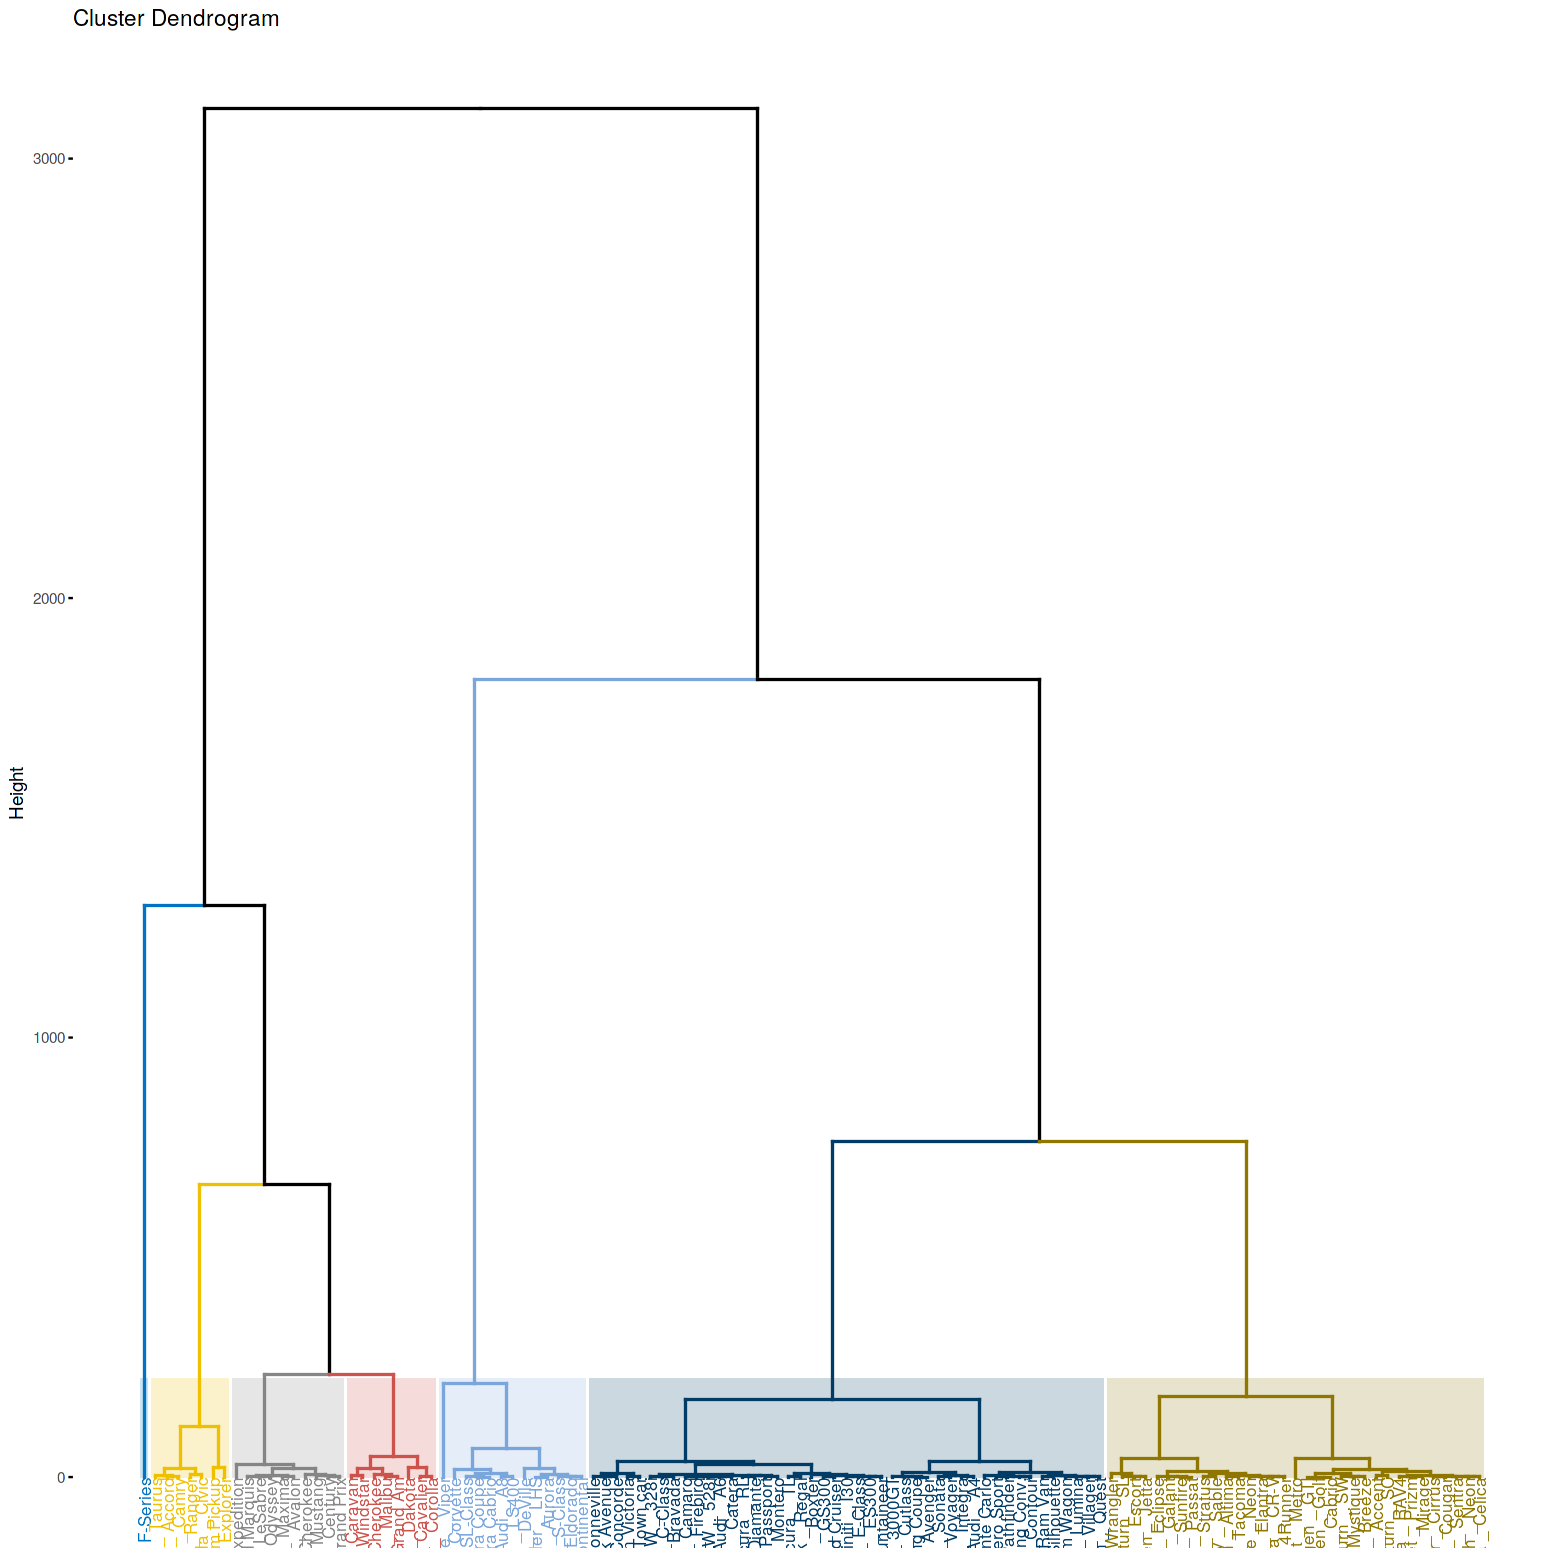

In [14]:
fviz_dend(res.hclust, 
                cex = 0.7,                     
                palette = "jco",              
                rect = TRUE, rect_fill = TRUE, 
                rect_border = "jco",           
                labels_track_height = 1.3,     
                k=7  ,                        
               
)


In order to benefit from the previous results on the principal components method, we will apply the Hierarchical classification to the PCA result.

The graph, below, shows that there are only 5 groups instead of 6, which explains the effect of reducing dimensionality using the PCA results. By analyzing the averages for each group, we find that going from group 1 to group 4, vehicle size and engine power increase while fuel efficiency decreases. However, the variable that represents the number of sales does not have a significant impact on this classification. We also find that the average of each variable in the cluster is very close to its overall average in all the clusters, this means that the rate of our variables is similar in all the clusters.

In [15]:
res.hcpc <- HCPC(res.pca, graph = FALSE)

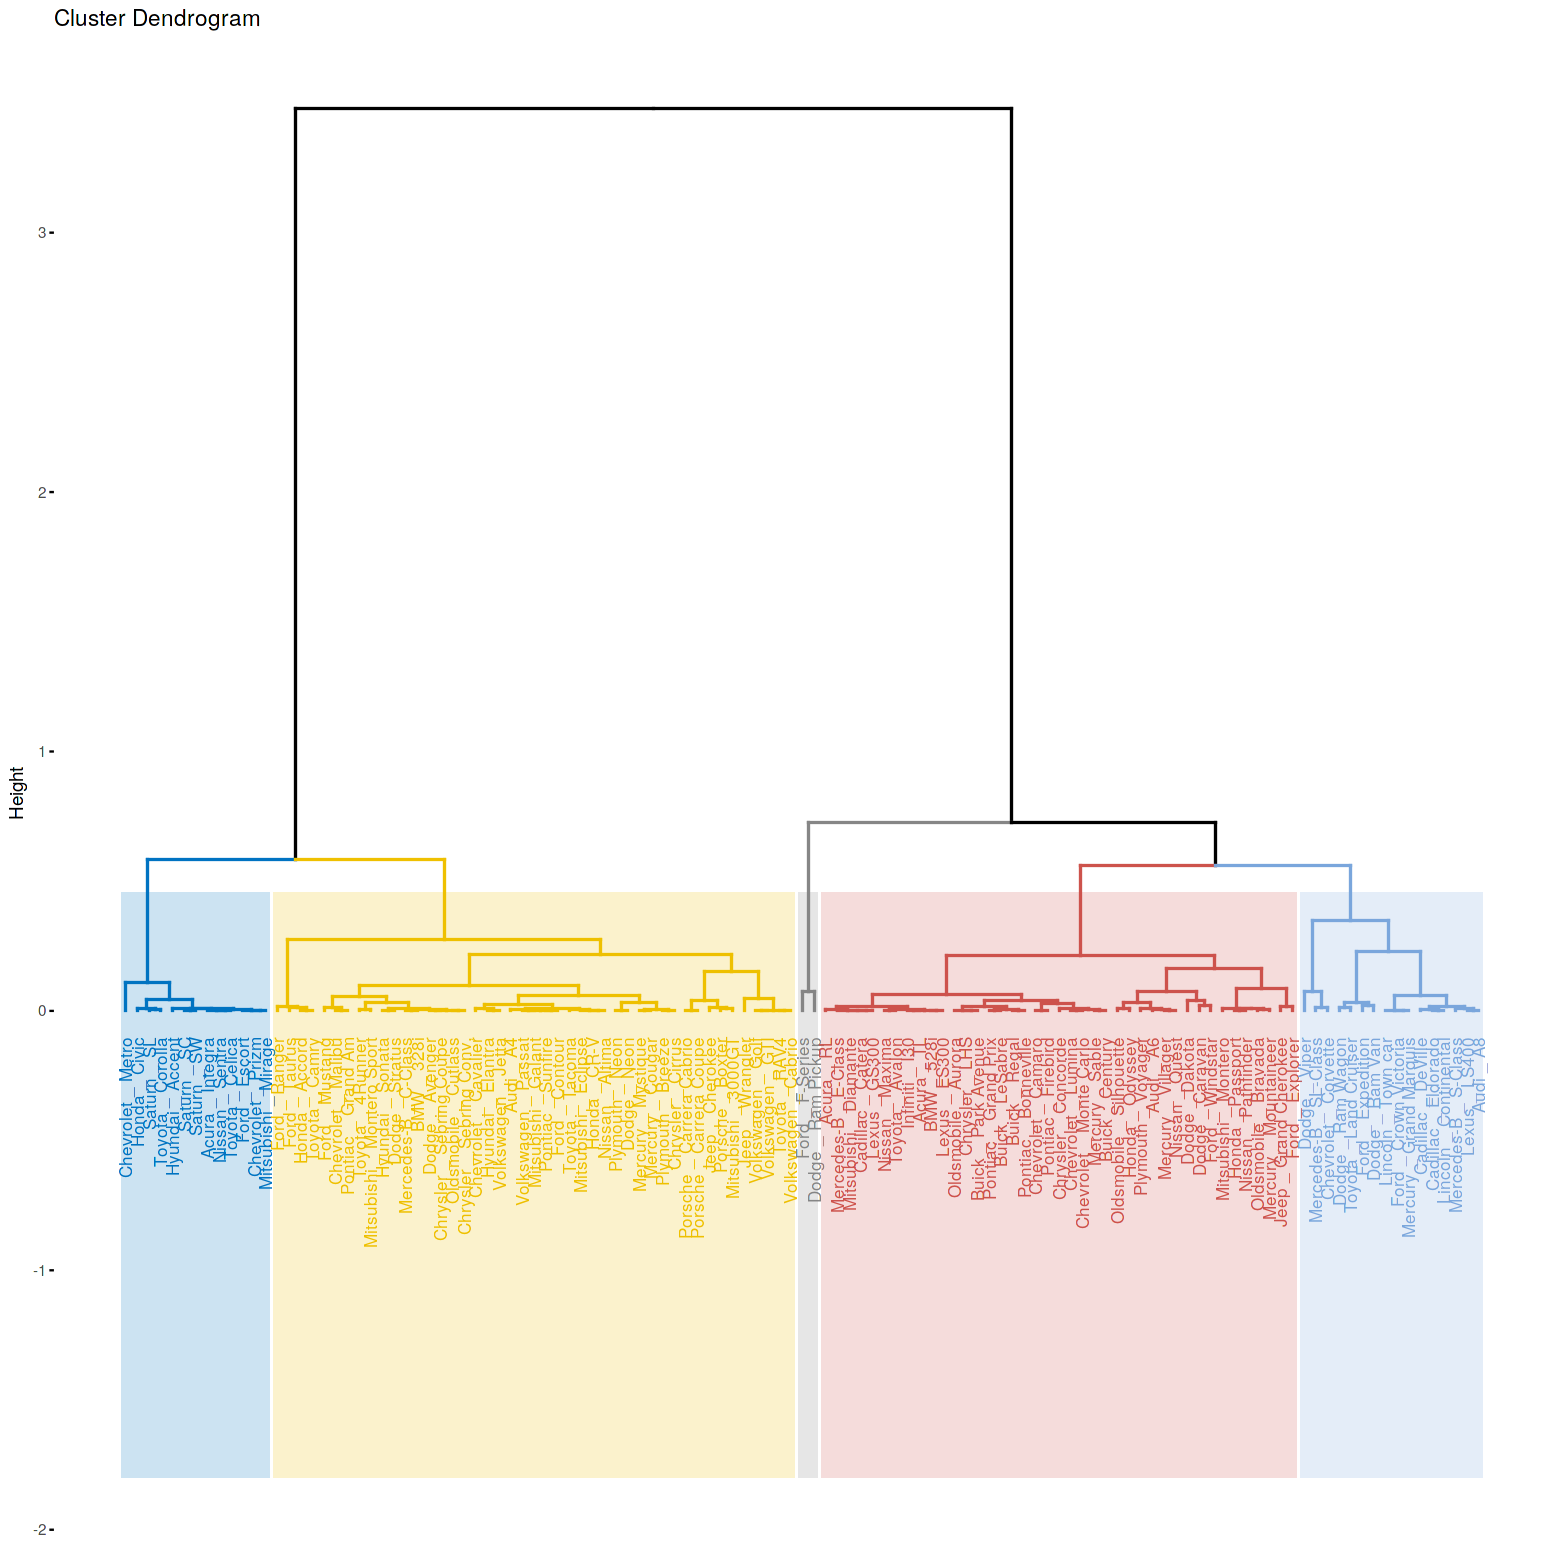

In [16]:


fviz_dend(res.hcpc, cex = 0.7,
          palette = "jco", 
          rect = TRUE, 
          rect_fill = TRUE,
          rect_border = "jco", 
          labels_track_height = 1.3, 
          k=7)


In [17]:
#the mean in category and overall for every cluster
  lapply(res.hcpc$desc.var$quanti, `[`,,c(2,3,6))

,Mean in category,Overall mean,p.value
Fuel_efficiency,30.136364,24.119658,1.155208e-12
Wheelbase,99.881818,107.326496,1.483113e-06
Width,67.559091,71.189744,8.629173e-08
Horsepower,116.000000,181.282051,6.646542e-09
Engine_size,1.854545,3.048718,3.839154e-09
Length,171.309091,187.717949,6.960139e-10
Fuel_capacity,13.181818,17.812821,2.117276e-10
Curb_weight,2.517045,3.324051,2.003714e-12
,Mean in category,Overall mean,p.value
Fuel_capacity,16.552941,17.812821,0.0215301160


# Multiple Correspondence analysis

Before applying the multiple correspondence analysis, let's add three qualitative variables based on the existing quantitative variables : 
 
  * **"Car_size"**: assuming the average length of a vehicle is around 170 inches(https://mechanicbase.com/cars/average-car-length/), the new variable divides the vehicle size into 3 levels: "Small_Car" "," Midsize_Car "and" Big_Car
  
  * **"Sales_in_thousands_level"**: this constitutes 3 intervals of the number of sales: <10000, [10k, 30k], [30k, 70k] and> 70k
  
  * **"Engine_size_level"**: this divides the vehicles into two intervals according to the dimensions of their cylinders: "<= 2 liters" and "> 2 liters"
  
In order to consolidate the three methods used in this notebook, we will use the results of the hierarchical classification and add a new variable containing the cluster number of each observation.

According to the results of the MCA function, the first two dimensions contain only 33% of the total inertia. It would therefore be necessary to examine the 3rd and the 4th axis to draw clear conclusions 

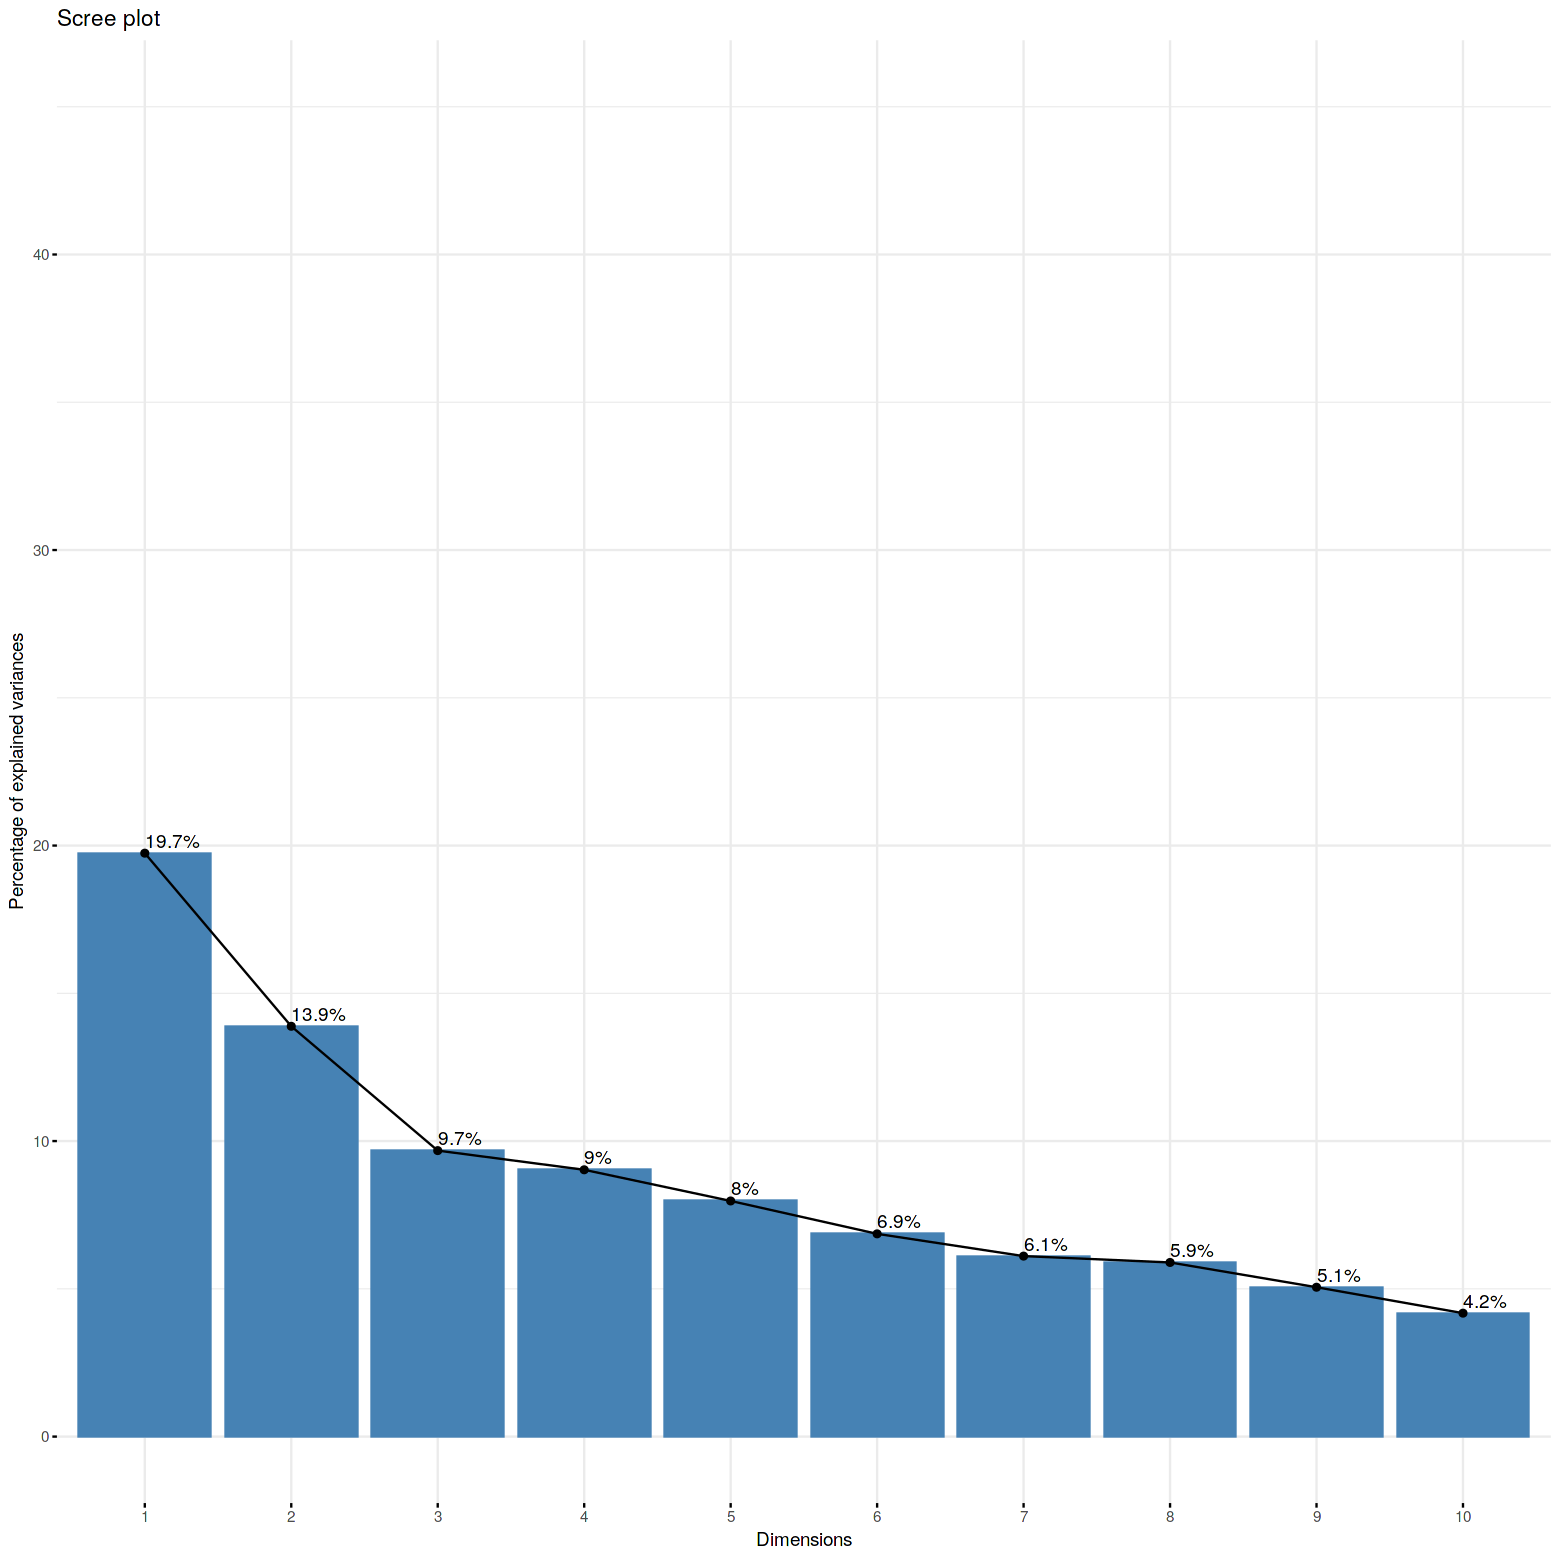

In [18]:

Car_sales$Car_size <- as.factor(ifelse((Car_sales$Length < 170), "Small_Car",
    ifelse((Car_sales$Length > 189),  "Big_Car", "Midsize_Car")))

Car_sales$Sales_in_thousands_level <- 
as.factor(ifelse((Car_sales$Sales_in_thousands < 10.0), "Sales < 10k",
ifelse((Car_sales$Sales_in_thousands  <= 30.0),  "Sales[10k,30k]",ifelse((Car_sales$Sales_in_thousands  <= 70.0),
"Sales[30k,70k]", "Sales > 70k"))))

Car_sales$Engine_Size_level <- as.factor(ifelse((Car_sales$Engine_size <= 2),
"Engine <= 2litres",ifelse((Car_sales$Engine_size   > 2),  "Engine >= 2litres", NA)))

# add number of cluster based on the the hierarchical classification done previously
Car_sales$clust <- res.hcpc$data.clust$clust


res.mca <- MCA (Car_sales[, 10:15], graph = FALSE)
fviz_screeplot (res.mca, addlabels = TRUE, ylim = c (0, 45))


The graph below shows the relationships between the categories of the following qualitative variables:

   * the categories that are grouped together, they have a similar profile (like: "germany", "Sales <10k", "High_Price") 
   * Categories that are positioned on opposite sides of the origin of the graph are negatively correlated.(such as: "United States" vs "small_car" and "Engine <= 2litres") 
  
The  graph also reveals the content of the clusters of the hierarchical classification. Cluster "1" includes small cars with a cylinder volume of less than 2 liters, cluster "3" is includes the American cars with a big cylinder and affordable price . Cluster "4" contains German cars which are expensive and less solded in the market. 

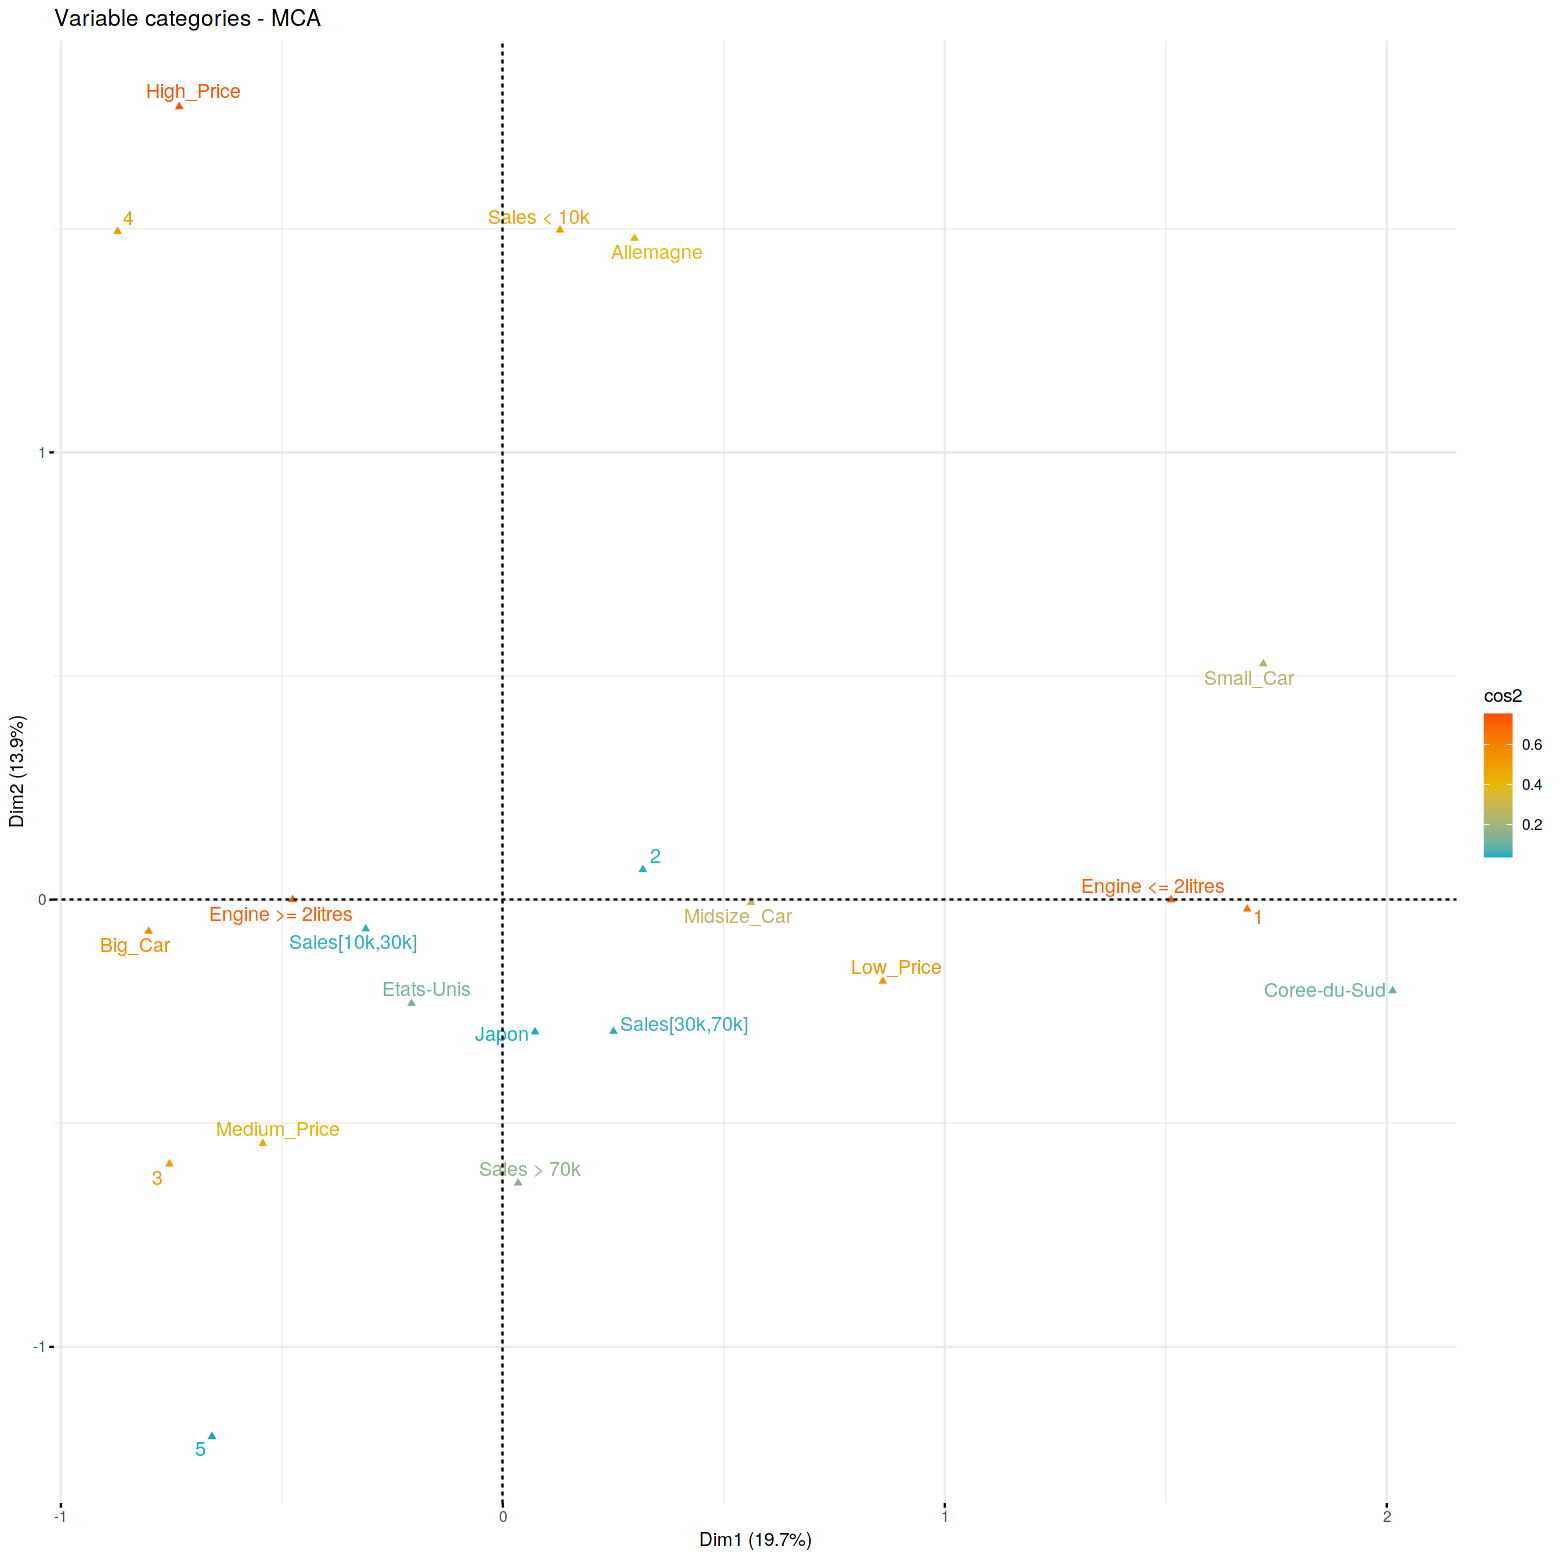

In [19]:

fviz_mca_var(res.mca, col.var = "cos2", gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE, ggtheme = theme_minimal())

# Conclusions

In conclusion, we can say that the three methods used are complementary.

First, the principal component analysis allowed us to analyze the part of our datasets containing the observations described by the quantitative variables. Thanks to this analysis, we were able to visualize our data on the two main axes representing less loss of information with 78% of the total inertia. We were also able to identify the similarities between individuals as well as the strong correlation of certain variables. , which can lead to the creation of synthetic variables which would summarize the performance of vehicles by a small number of variables.

Then, using the hierarchical classification, we were able to divide our variables into 6 homogeneous groups with similar properties. Then we managed to reduce the number of groups to 5 using the PCA results as input. 

Finally, factor analysis of multiple correspondence has been very useful for us to summarize and visualize our data according to categorical variables. Despite the low rate of inertia represented by the first axes, we were able to detect existing associations between the categories of variables and the content of each cluster.